{'纹理': {'清晰': {'根蒂': {'蜷缩': '是', '稍蜷': {'色泽': {'浅白': '是', '青绿': '是', '乌黑': {'触感': {'硬滑': '是', '软粘': '否'}}}}, '硬挺': '否'}}, '稍糊': {'触感': {'软粘': '是', '硬滑': '否'}}, '模糊': '否'}}


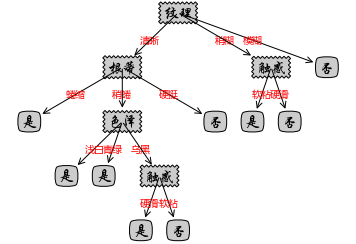

In [4]:
from math import log2
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


# 统计label出现次数
def get_counts(data):
    total = len(data)
    results = {}
    for d in data:
        results[d[-1]] = results.get(d[-1], 0) + 1
    return results, total

# 计算信息熵
def calcu_entropy(data):
    results, total = get_counts(data)
    ent = sum([-1.0*v/total*log2(v/total) for v in results.values()])
    return ent

#计算每一个属性的信息增益
def calcu_each_gain(column, update_data):
    total = len(column)
    #以特征列为基准来分组标签
    grouped = update_data.iloc[:, -1].groupby(by=column)
    #for g in list(grouped):
    #    con_ent+=len(g[1])/total*entropy(g[1])
    temp = sum([len(g[1])/total*calcu_entropy(g[1]) for g in list(grouped)])
    return calcu_entropy(update_data.iloc[:, -1]) - temp




#找到最大增益作为分支准则
#返回（属性，增益）
def get_max_gain(temp_data):
    #计算每一个特征的增益，排序找出最大值
    #for feature_name in temp_data[:,:-1]取出的是属性名
    columns_entropy = [(col, calcu_each_gain(temp_data[col], temp_data)) for col in temp_data.iloc[:, :-1]]
    columns_entropy = sorted(columns_entropy, key=lambda f: f[1], reverse=True)
    return columns_entropy[0]




#去掉数据中已存在的列属性内容
#并返回其每一个子节点对应的属性及样本数据
def drop_exist_feature(data, best_feature):
    attr = pd.unique(data[best_feature])
    new_data = [(nd, data[data[best_feature] == nd]) for nd in attr]
    new_data = [(n[0], n[1].drop([best_feature], axis=1)) for n in new_data]
    return new_data

#获取最多的label
def get_most_label(label_list):
    label_dict = {}
    for l in label_list:
        label_dict[l] = label_dict.get(l, 0) + 1
    sorted_label = sorted(label_dict.items(), key=lambda ll: ll[1], reverse=True)
    return sorted_label[0][0]

#创建决策树
#data_set为数据集
#column_count为属性特征集合

def create_tree(data_set,column_count):
    label_list=data_set.iloc[:,-1]#取出标签类
    if len(pd.unique(label_list))==1:
        #当前结点样本完全属于同一类，返回叶结点
        return label_list.values[0]
    if all([len(pd.unique(data_set[i]))==1 for i in data_set.iloc[:,:-1].columns]):
        #某一属性下面只有一种特征，不可再分，返回叶结点，类标为种类最多的点
        return get_most_label(label_list)
    best_attr=get_max_gain(data_set)[0]
    #返回分支表现最好的属性名
    tree={best_attr:{}}
    #最好的属性下面的特征
    exist_attr=pd.unique(data_set[best_attr])
    #column_count为属性及特征集合
    if len(exist_attr)!=len(column_count[best_attr]):
        #即属性中某一特征的样本集为空
        no_exist_attr=set(column_count[best_attr])-set(exist_attr)
        for nea in no_exist_attr:
            tree[best_attr][nea]=get_most_label(label_list)
    for item in drop_exist_feature(data_set,best_attr):
        tree[best_attr][item[0]]=create_tree(item[1],column_count)
    return tree




# 决策树绘制基本参考《机器学习实战》书内的代码以及博客：http://blog.csdn.net/c406495762/article/details/76262487
# 获取树的叶子节点数目
def get_num_leafs(decision_tree):
    num_leafs = 0
    first_str = next(iter(decision_tree))
    second_dict = decision_tree[first_str]
    for k in second_dict.keys():
        if isinstance(second_dict[k], dict):
            num_leafs += get_num_leafs(second_dict[k])
        else:
            num_leafs += 1
    return num_leafs

# 获取树的深度
def get_tree_depth(decision_tree):
    max_depth = 0
    first_str = next(iter(decision_tree))
    second_dict = decision_tree[first_str]
    for k in second_dict.keys():
        if isinstance(second_dict[k], dict):
            this_depth = 1 + get_tree_depth(second_dict[k])
        else:
            this_depth = 1
        if this_depth > max_depth:
            max_depth = this_depth
    return max_depth

# 绘制节点
def plot_node(node_txt, center_pt, parent_pt, node_type):
    arrow_args = dict(arrowstyle='<-')
    font = FontProperties(fname=r'C:\Windows\Fonts\STXINGKA.TTF', size=15)
    create_plot.ax1.annotate(node_txt, xy=parent_pt,  xycoords='axes fraction', xytext=center_pt,
                            textcoords='axes fraction', va="center", ha="center", bbox=node_type,
                            arrowprops=arrow_args, FontProperties=font)

# 标注划分属性
def plot_mid_text(cntr_pt, parent_pt, txt_str):
    font = FontProperties(fname=r'C:\Windows\Fonts\MSYH.TTC', size=10)
    x_mid = (parent_pt[0] - cntr_pt[0]) / 2.0 + cntr_pt[0]
    y_mid = (parent_pt[1] - cntr_pt[1]) / 2.0 + cntr_pt[1]
    create_plot.ax1.text(x_mid, y_mid, txt_str, va="center", ha="center", color='red', FontProperties=font)

# 绘制决策树
def plot_tree(decision_tree, parent_pt, node_txt):
    d_node = dict(boxstyle="sawtooth", fc="0.8")
    leaf_node = dict(boxstyle="round4", fc='0.8')
    num_leafs = get_num_leafs(decision_tree)
    first_str = next(iter(decision_tree))
    cntr_pt = (plot_tree.xoff + (1.0 +float(num_leafs))/2.0/plot_tree.totalW, plot_tree.yoff)
    plot_mid_text(cntr_pt, parent_pt, node_txt)
    plot_node(first_str, cntr_pt, parent_pt, d_node)
    second_dict = decision_tree[first_str]
    plot_tree.yoff = plot_tree.yoff - 1.0/plot_tree.totalD
    for k in second_dict.keys():
        if isinstance(second_dict[k], dict):
            plot_tree(second_dict[k], cntr_pt, k)
        else:
            plot_tree.xoff = plot_tree.xoff + 1.0/plot_tree.totalW
            plot_node(second_dict[k], (plot_tree.xoff, plot_tree.yoff), cntr_pt, leaf_node)
            plot_mid_text((plot_tree.xoff, plot_tree.yoff), cntr_pt, k)
    plot_tree.yoff = plot_tree.yoff + 1.0/plot_tree.totalD

def create_plot(dtree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plot_tree.totalW = float(get_num_leafs(dtree))
    plot_tree.totalD = float(get_tree_depth(dtree))
    plot_tree.xoff = -0.5/plot_tree.totalW
    plot_tree.yoff = 1.0
    plot_tree(dtree, (0.5, 1.0), '')
    plt.show()



if __name__ == '__main__':
    my_data = pd.read_csv(r'E:\Repository\algorithms\xigua.txt',sep=',')
    column_count = dict([(ds, list(pd.unique(my_data[ds]))) for ds in my_data.iloc[:, :-1].columns])
    d_tree = create_tree(my_data, column_count)
    print(d_tree)
    create_plot(d_tree) 
    
    


    

        


        